In [ ]:
import copy
from typing import List

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
%matplotlib inline

In [403]:
class AccessControlQueue:
    def __init__(self):
        self.MAX_LEN = 10
        self.PRIORITIES = [1,2,4,8]
        self.state = None
    
    def step(self,action):
        free = self.state[0]
        priority = self.PRIORITIES[self.state[1]]
        if free == 0 and action == 1:
            raise Exception("Can't accept when queue is full")
        for i in range(self.MAX_LEN - free):
            if np.random.rand() <= 0.06:
                free+=1
        free-=action
        self.state = (free,self._sample_priority())
        return self.state,priority if action else 0

    def reset(self):
        self.state = (self.MAX_LEN,self._sample_priority())
        return self.state
        
    def _sample_priority(self):
        return np.random.randint(0,4)
    

<h1> Let's first calculate average reward of random policy </h1>

1.6505662269751862


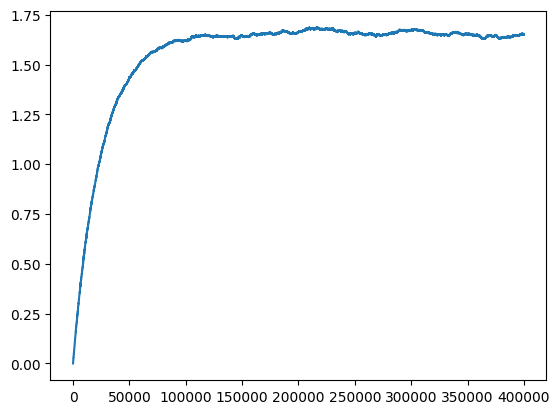

In [404]:
env = AccessControlQueue()
free,_ =env.reset()
rbar = 0
track = []
for i in range(400000):
    if free == 0 or np.random.rand() < 0.5:
        (free,_),reward = env.step(0)
    else:
        (free,_),reward = env.step(1)
    rbar = rbar + 0.00004*(reward - rbar)
    track.append(rbar)
plt.plot(track)
print(rbar)

<h1> Semi-gradient differential TD(0) SARSA </h1>

In [409]:
num_samples = int(2e6)
alpha = 1e-2
beta = 1e-4
q = np.zeros((11,4,2))
rbar = 0.
epsilon = 0.1
state = env.reset()
action = np.random.randint(0,2)
track = []
track_rbar = []
for i in range(num_samples):
    next_state,reward = env.step(action)
    if next_state[0] == 0:
        next_action = 0
    elif np.random.rand() <= epsilon:
        next_action = np.random.randint(0,2)
    else:
        next_action = np.argmax(q[next_state[0],next_state[1]])
    delta = (reward-1)/7 - rbar + q[next_state[0],next_state[1],next_action] - q[state[0],state[1],action]
    q[state[0],state[1],action] = q[state[0],state[1],action] +alpha * delta
    rbar = rbar + beta*delta 
    track.append(delta**2)
    track_rbar.append(rbar*7+1)
    state = next_state
    action = next_action
print(rbar*7+1)


2.5779547254776416


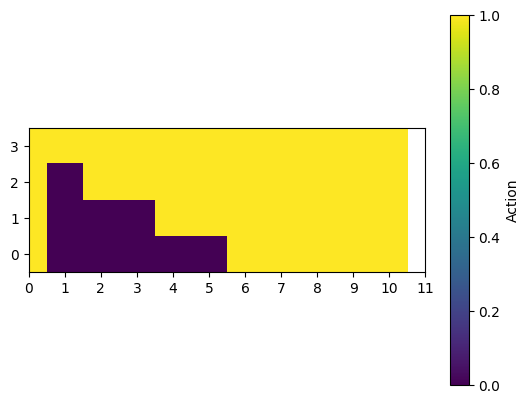

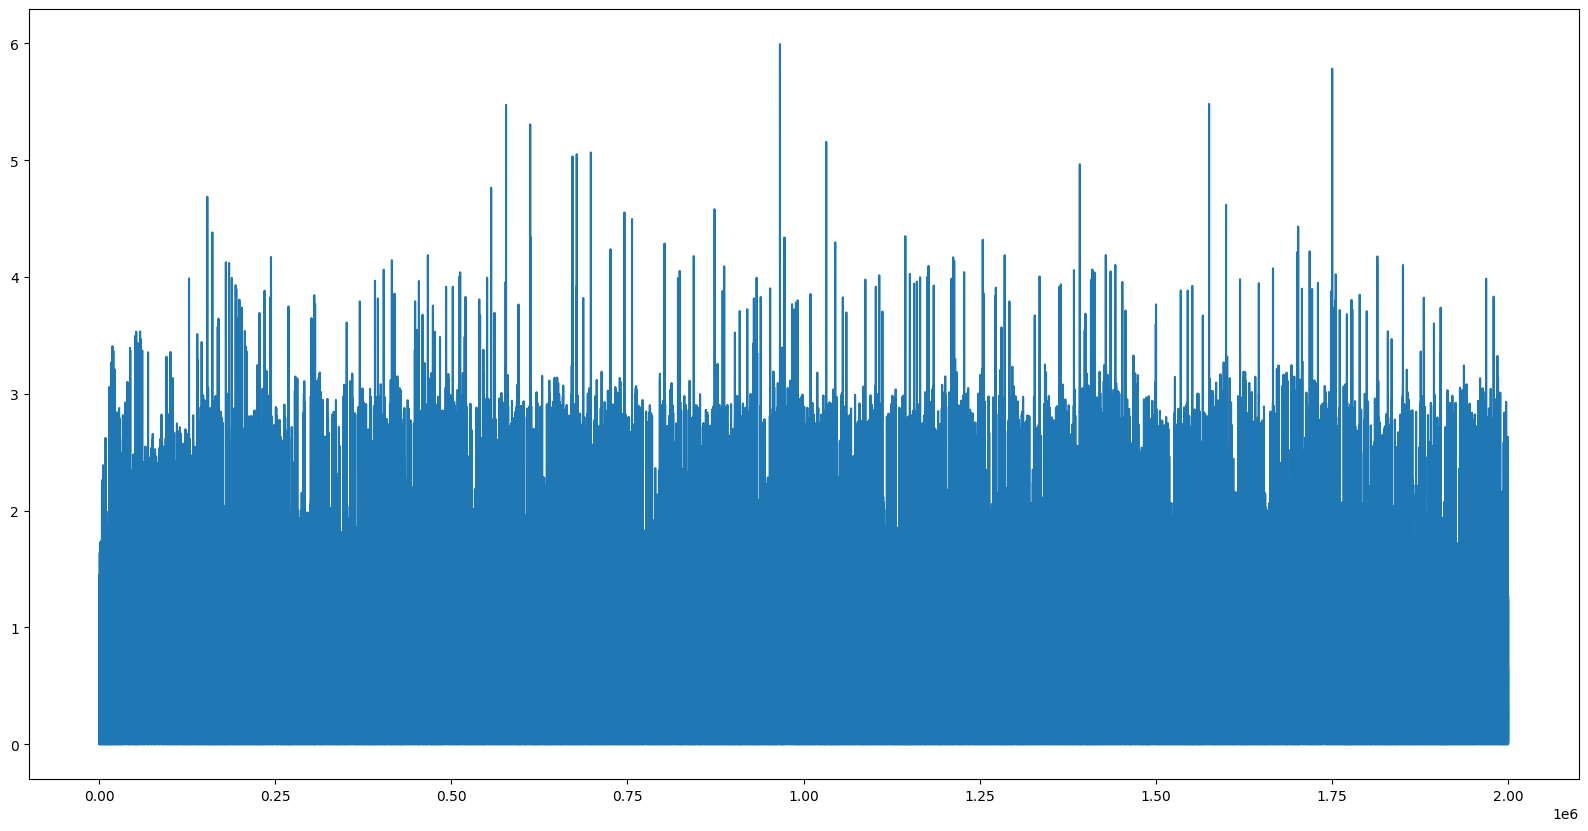

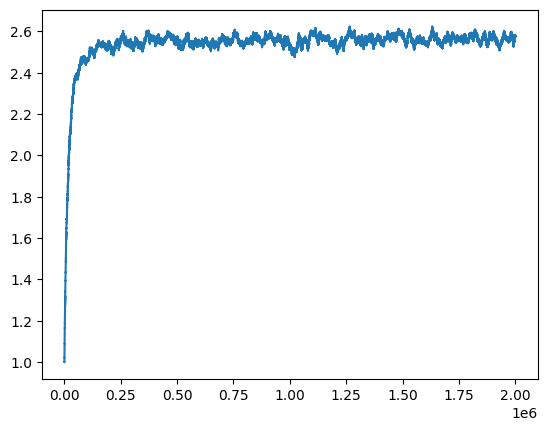

In [410]:
q_map = np.argmax(q,axis=2)
q_map = q_map.T
plt.imshow(q_map, cmap="viridis", interpolation="none", origin='lower')
plt.xlim(1,10)
plt.xticks(np.arange(0,12, 1.0))
plt.colorbar(label="Action")
plt.figure(figsize=(20,10))
plt.plot(track)
plt.figure()
plt.plot(track_rbar)

<h1> Semi-gradient differential TD(0) Q-learning </h1>

In [411]:
import copy
num_samples = int(2e6)
alpha = 1e-2
beta = 1e-4
q1 = copy.deepcopy(q)
q2 = copy.deepcopy(q)
rbar = copy.deepcopy(rbar)
state = env.reset()
action = np.random.randint(0,2)
track = []
track_rbar = []
track_q = []
for i in range(num_samples):
    next_state,reward = env.step(action)
    if next_state[0] == 0:
        next_action = 0
    else:
        next_action = np.argmax((q1+q2)[*next_state])
    if np.random.rand() < 0.5:
        delta = (reward-1)/7 - rbar + q2[next_state[0],next_state[1],np.argmax(q1[next_state[0],next_state[1]])] - q1[state[0],state[1],action]
        q1[state[0],state[1],action] = q1[state[0],state[1],action] +alpha * delta
    else:
        delta = (reward-1)/7 - rbar + q1[next_state[0],next_state[1],np.argmax(q2[next_state[0],next_state[1]])] - q2[state[0],state[1],action]
        q2[state[0],state[1],action] = q2[state[0],state[1],action] +alpha * delta
    rbar = rbar + beta*delta 
    track_q.append((q1[1,3,0]+q2[1,3,0])/2.)
    track.append(delta**2)
    track_rbar.append(rbar*7+1)
    state = next_state
    action = next_action
print(rbar*7+1)


2.8695635191260993


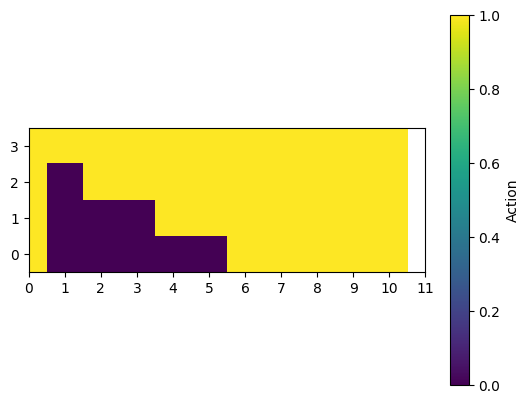

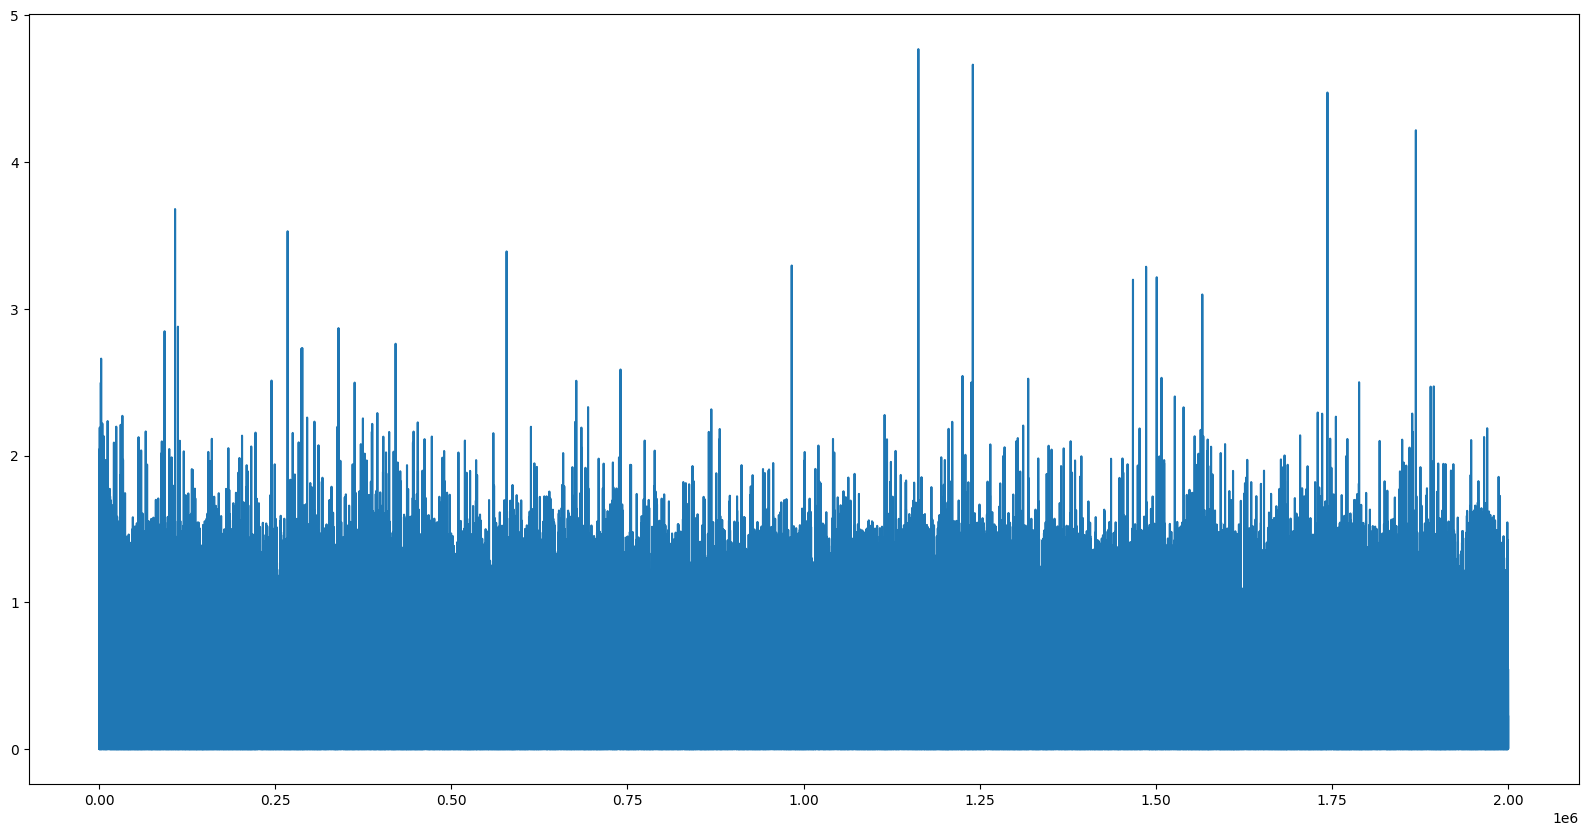

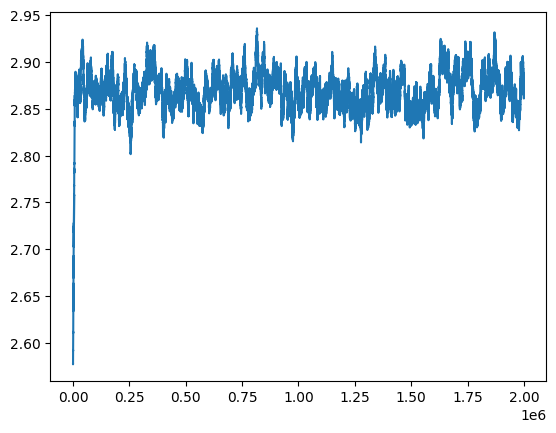

In [412]:
q_map = np.argmax(q,axis=2)
q_map = q_map.T
plt.imshow(q_map, cmap="viridis", interpolation="none", origin='lower')
plt.xlim(1,10)
plt.xticks(np.arange(0,12, 1.0))
plt.colorbar(label="Action")
plt.figure(figsize=(20,10))
plt.plot(track)
plt.figure()
plt.plot(track_rbar)

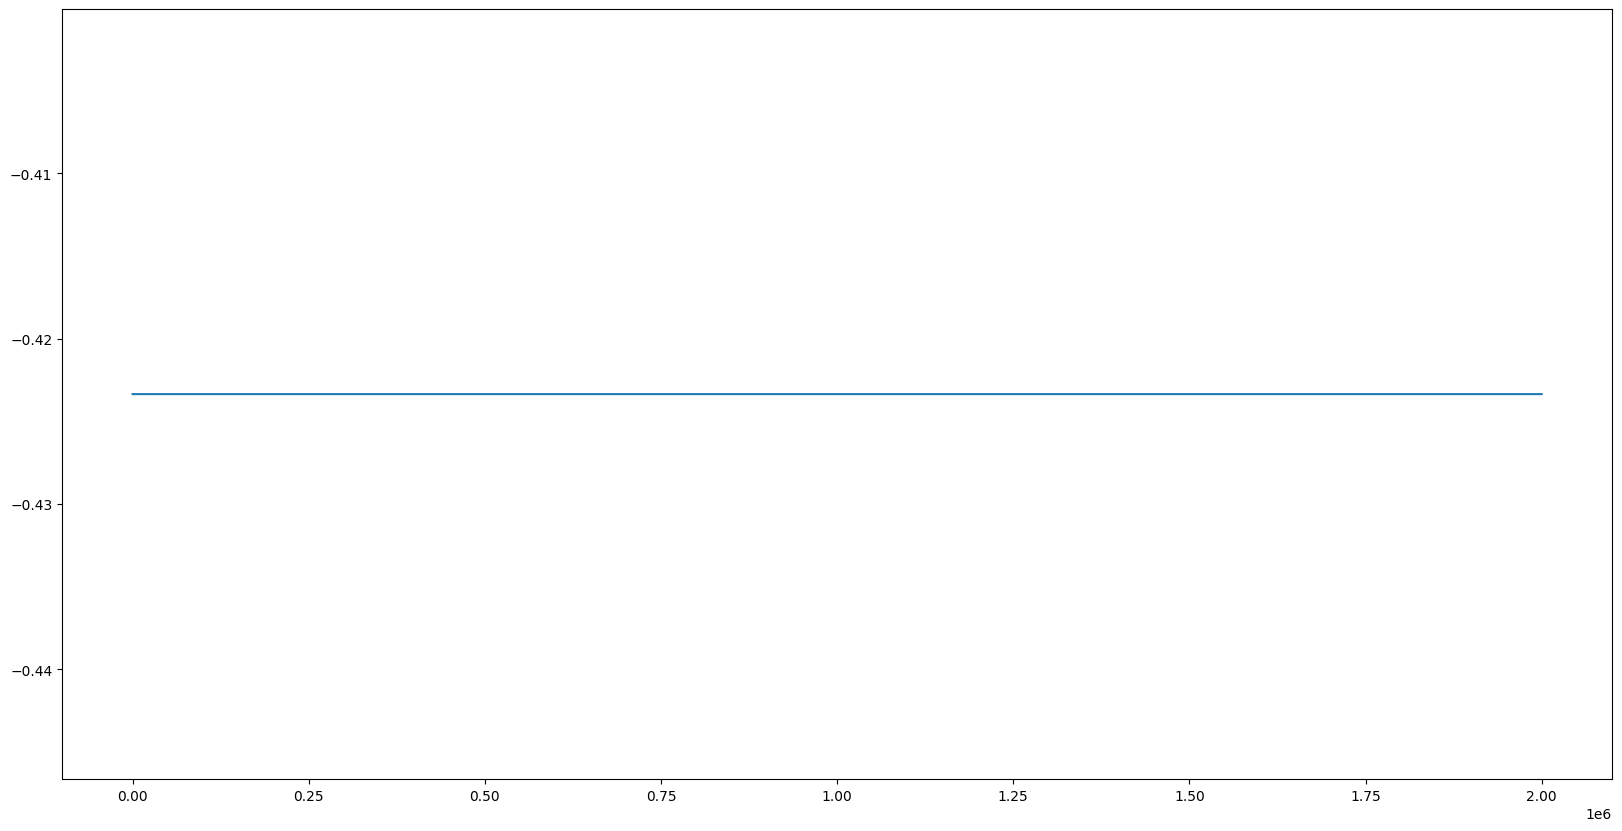

In [413]:
plt.figure(figsize=(20,10))
plt.plot(track_q)

<h1> Evaluation </h1>

2.671551880757254


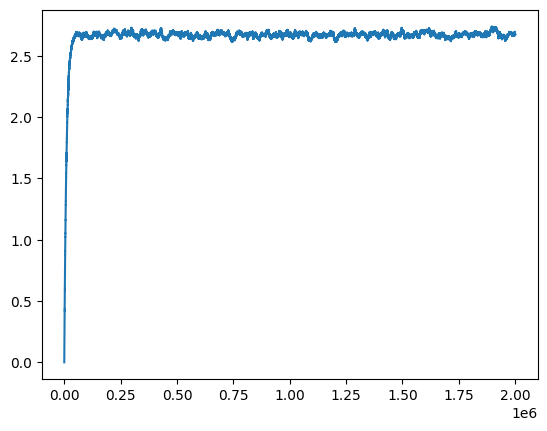

In [414]:
state = env.reset()
rt = 0
track = []
for i in range(int(2e6)):
    action = np.argmax(q[*state])
    if state[0] == 0:
        action = 0
    next_state,reward = env.step(action)
    rt = rt + 0.0001 * (reward - rt)
    track.append(rt)
    state = next_state

plt.figure()
plt.plot(track)
print(rt)
